<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/cat_vs_dog_vgg16/cat_vs_dog_vgg16_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
import pathlib
import os

# Configurations

In [2]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_CLASSES = 2

# Download and Import Dataset

In [3]:
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#!/bin/bash
!kaggle datasets download karakaggle/kaggle-cat-vs-dog-dataset
!unzip kaggle-cat-vs-dog-dataset.zip
!rm kaggle-cat-vs-dog-dataset.zip

In [14]:
# Remove corrupted images
import os
from PIL import Image

num_skipped_images = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("/content/kagglecatsanddogs_3367a/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped_images += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped_images} images.")


Deleted 1580 images.


In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/kagglecatsanddogs_3367a/PetImages",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/kagglecatsanddogs_3367a/PetImages",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 23379 files belonging to 2 classes.
Using 18704 files for training.
Found 23379 files belonging to 2 classes.
Using 4675 files for validation.


In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32,)


## Check Images Sample

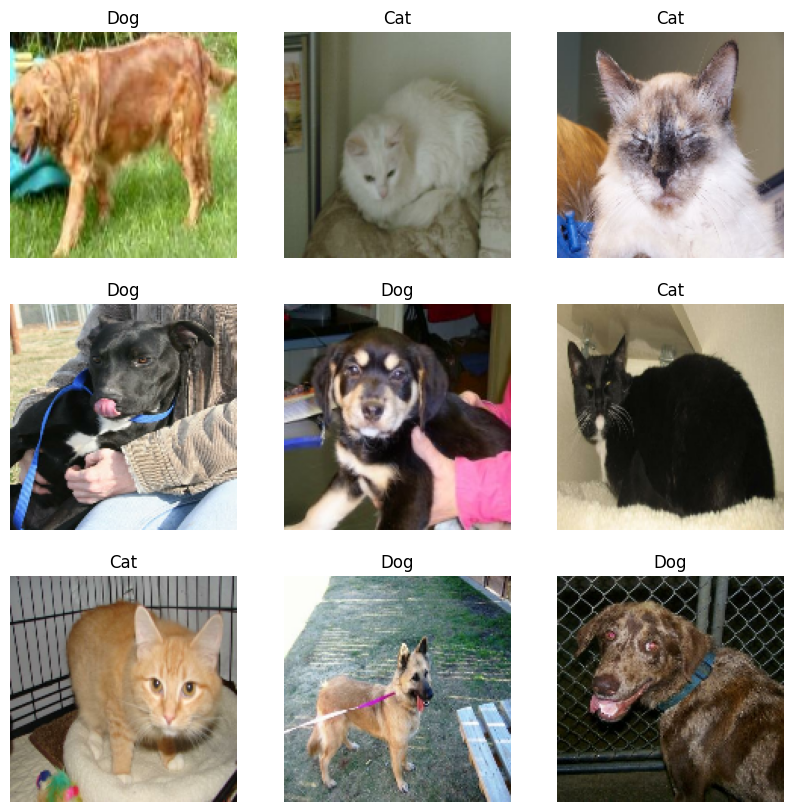

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

# Preprocess

In [19]:
def preprocess_input(image, label):
    image = image / 255.0
    return image, label

train_ds = train_ds.map(preprocess_input).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_input).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load `VGG16`

In [20]:
base_model = VGG16(
    input_shape=IMAGE_SIZE + (3, ),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False
print(f"Number of layers in the base model: {len(base_model.trainable_weights)}")

Number of layers in the base model: 0


In [11]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Insert New Heads

In [21]:
def build_feature_extraction_model(base_model, num_classes):
    inputs = Input(shape=(IMAGE_SIZE + (3, )))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D(name="gap_layer")(x)
    x = Dense(512, activation="relu", name="dense_hidden")(x)
    x = Dropout(0.5, name="dropout")(x)
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(x)
    model = Model(inputs, outputs)
    return model

model = build_feature_extraction_model(base_model, NUM_CLASSES)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap_layer                       │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile

In [22]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Training Phase
INITIAL_EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 93s 155ms/step - accuracy: 0.8220 - loss: 0.3791 - val_accuracy: 0.8877 - val_loss: 0.2622
Epoch 2/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 76s 129ms/step - accuracy: 0.8865 - loss: 0.2615 - val_accuracy: 0.8988 - val_loss: 0.2401
Epoch 3/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.8948 - loss: 0.2427 - val_accuracy: 0.9020 - val_loss: 0.2324
Epoch 4/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.9009 - loss: 0.2343 - val_accuracy: 0.9022 - val_loss: 0.2289
Epoch 5/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.9022 - loss: 0.2262 - val_accuracy: 0.9018 - val_loss: 0.2301
Epoch 6/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 75s 128ms/step - accuracy: 0.9054 - loss: 0.2223 - val_accuracy: 0.9110 - val_loss: 0.2194
Epoch 7/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 75s 128ms/step - accuracy: 0.9098 - loss: 0.2138 - val_accuracy: 0.9076 - val_loss: 0.2183
Epoch 8/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.9094 - loss: 0

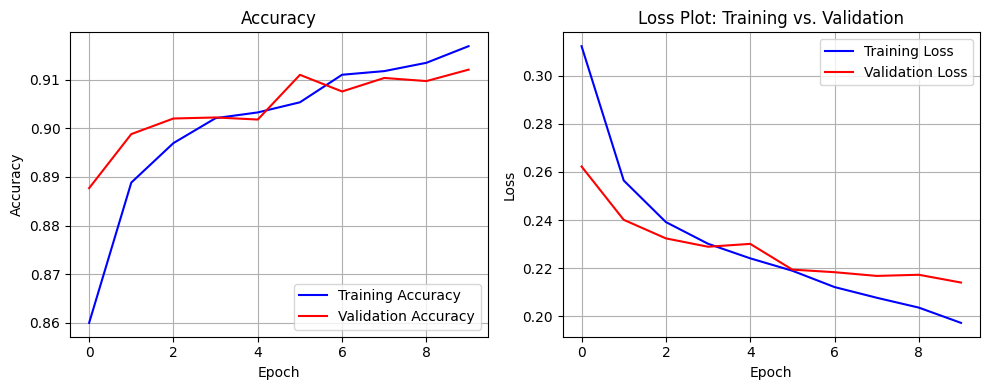

In [24]:
def plot_learning_curves(history, initial_epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(initial_epochs)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1) # Plot 1 of 2
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)


    plt.subplot(1, 2, 2) # Plot 2 of 2
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.legend(loc='upper right')
    plt.title('Loss Plot: Training vs. Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

plot_learning_curves(history, INITIAL_EPOCHS)